# Models Development
### Binary and Multiclass Classification using Hugging Face, RayTune and Weights&Biases

 **Authors:** Álvaro D. Gómez Antón, Sabah Serhir Serhir, Elisa M. Ramos Monsoriu, Lautaro Paniati Altamirano, Estefania Solís Valverde, Alba Valverde Porcar

<br></br>

<div style="text-align: right"><i>Explaining Online Sexism: Language Models and a Mexican Perspective</i></div>
    
<div style="text-align: right">A Capstone Project by United Nations International Computing Centre (<a href="https://www.unicc.org/">UNICC</a>) and Universitat Politècnica de València (<a href="https://www.upv.es/es">UPV</a>) </div>

---

In this notebook, we embark on a journey to detect and classify sexism content in Spanish tweets. With the rise of social media, online sexism has become a pressing issue that requires effective monitoring and intervention. Leveraging the power of deep learning and language models, we aim to develop a robust classification system that can accurately identify and categorize sexist content in Spanish text.

To tackle our objectives, we adopt a fine-tuning approach using a pretrained large language model (LLM). However, we take a unique path by exploring two distinct training strategies. The first approach involves utilizing only the original Spanish data, while the second incorporates both the original and translated data.

The incorporation of translated data serves a crucial purpose – to evaluate the impact of language translation on the classification task. Deep learning models, including LLMs, often exhibit improved performance with larger training datasets. However, preserving the original meaning of the text becomes a challenge during translation. Conventional translation tools may struggle to retain the intended meaning, potentially affecting the performance of our models.

Thus, we set out to investigate whether large language models, such as GPT-3.5, can effectively translate text while maintaining its meaning and valuable information. If the results obtained using the translated data are equal to or better than those achieved solely with Spanish data, it would signify the capacity of these models to preserve meaning during translation. Such a discovery would be significant, as it suggests a promising solution to overcome data scarcity in specific-language natural language processing (NLP) problems. Currently, languages other than widely used ones like English often lack sufficient data, limiting the full potential of artificial intelligence and machine learning in these contexts.

Conversely, if the performance using translated data is worse, it would indicate that large language models have not yet reached their full efficiency in overcoming language barriers. Understanding these outcomes will provide valuable insights into the capabilities and limitations of language models in addressing the challenges of online sexism in Spanish.

Throughout this notebook, we will guide you through the steps of training and fine-tuning our models using the 🤗 Hugging Face ecosystem, analyzing their performance using both aforementioned approaches, optimizing hyperparameters with RayTune, and evaluating the results using the Weights&Biases platform. By the end, we aim to contribute to the development of effective tools for combating online sexism, promoting safer digital spaces, and fostering inclusive communities.

**Requirements**

In [ ]:
!pip install transformers
!pip install datasets
!pip install evaluate
#!pip install accelerate
!pip install git+https://github.com/huggingface/accelerate
!pip install 'ray[tune]'
!pip install wandb

## The Data

Our dataset consists of labeled tweets, differentiating between sexism and non-sexism, with additional categorization of the specific types of sexism displayed. It encompasses original Spanish tweets collected from diverse sources, as well as translated tweets that were originally in English and subsequently translated to Mexican Spanish using GPT-3.5. Mexican Spanish because the aim of this modelos is to be used in the MExican scenario. For a more comprehensive understanding of the data preparation steps, we encourage you to refer to the "1-data-preparation.ipynb" notebook. 

In [17]:
data = pd.read_csv("../data/transformed/gold_data.tsv", sep="\t")
data

,original_id,text,sexist,type,language,dataset
0,0,"no sabía que ""random"" era una opción.",0,non-sexist,es-mx,callme
1,1,los dos últimos deberían haberse ido.,0,non-sexist,es-mx,callme
2,2,"""ladyboner"" merece mucho más crédito que ""dude...",0,non-sexist,es-mx,callme
3,3,"a partir de ahora se llamará ""sourpuss"".",0,non-sexist,es-mx,callme
4,4,tarah w sacrificó a varias mujeres para ganar ...,0,non-sexist,es-mx,callme
...,...,...,...,...,...,...
58757,1047687262455177217,"yo no puedo darte luz todos los días, pero si ...",0,non-sexist,es,metwo
58758,1064482731739045888,que bien! aunque digan que las mujeres no debe...,0,non-sexist,es,metwo
58759,1040584804536856577,y misoginia las pelotas no quiero que vengas a...,0,non-sexist,es,metwo
58760,1051458429280235520,"""imaginen el tipo de sociedad mojigata y castr...",0,non-sexist,es,metwo


### Initial Preparation

For the initial training approach, we worked with a Spanish dataset consisting of 11,479 tweets. The tweets were labeled as either sexist or non-sexist, with a quite balanced distribution of approximately 46% and 54% respectively. In the second training approach, which involved incorporating translations, a larger dataset of 58,399 tweets was utilized. However, this dataset exhibited an imbalanced label distribution, with approximately 68.5% classified as non-sexist and 31.5% classified as sexist. To ensure a fair comparison between the two approaches, we needed to address this imbalance.

We decided to adjust the positive class ratio in the translated dataset to match that of the Spanish dataset, which was 45%. To achieve this, we employed a technique called undersampling. By randomly discarding instances from the majority class (non-sexist), we reduced its percentage in the dataset, resulting in a more balanced distribution. This adjusted dataset served as the final training data for our models.

In [18]:
def balance_data_with_undersampling(df, positive_ratio) -> pd.DataFrame:
    """
    Balances the data by performing undersampling on the majority class.

    This function takes a DataFrame containing labeled data and performs undersampling
    on the majority class to balance the distribution of positive and negative instances.
    It ensures that the positive-to-negative ratio in the resulting dataset is not higher
    than the specified positive ratio.

    Args:
        - df (pandas.DataFrame): The DataFrame containing the labeled data.
        - positive_ratio (float): The desired positive-to-negative ratio after balancing.

    Returns:
        pandas.DataFrame: The balanced dataset after performing undersampling.

    """
    df = df.copy()
    
    # Calculate the actual positive count and ratio in the data frame
    actual_pos_count = df.label.sum()
    actual_pos_ratio = actual_pos_count / len(df)
    
    # Check if the actual positive ratio is higher than the desired positive ratio
    _changed = False
    if actual_pos_ratio > positive_ratio:
        # Invert the labels if the actual positive ratio is higher
        df.label = df.label.apply(lambda x: not x)
        actual_pos_count = len(df) - actual_pos_count
        actual_pos_ratio = 1 - actual_pos_ratio
        positive_ratio = 1 - positive_ratio
        _changed = True
    
    # Get all the positive instances
    pos_instances = df.loc[df.label == 1, :]
    
    # Undersample the negative class
    neg_instances_allowed = int(actual_pos_count * ((1 - positive_ratio) / positive_ratio))
    neg_instances = df.loc[df.label == 0, :].sample(n=neg_instances_allowed)
    
    # Concatenate positive and negative instances to create a balanced dataset
    balanced_data = pd.concat([pos_instances, neg_instances], axis=0)
    
    # Revert the label inversion if performed earlier
    if _changed:
        balanced_data.label = balanced_data.label.apply(lambda x: not x).astype(int)
    
    return balanced_data

### Adapting to 🤗 Hugging Face Ecosystem

To adapt our workflow to the 🤗 Hugging Face ecosystem, we introduced the `SexismDataset` object. This object serves as a versatile solution for efficient data preparation and tokenization in both the detection and classification tasks. It accepts a filepath or DataFrame as input, along with the task name (detection or classification) and an optional model checkpoint for tokenization.

The SexismDataset object streamlines the data preparation process by loading the data and performing necessary preprocessing steps. For instance, it can rename columns to match the requirements of the task at hand (e.g., "text" and "label" for text classification fine-tuning). Additionally, it applies undersampling to balance the dataset for the detection task and performs label encoding for the classification task. The dataset is then split into training, validation, and test sets in a ratio of 75:15:10, respectively.

To facilitate tokenization, the `SexismDataset` object leverages the tokenizers provided by 🤗 Hugging Face. It tokenizes the text data, taking into account a maximum sequence length of 512 tokens, and stores the tokenized representations of the dataset.

By encapsulating the data preparation and tokenization processes within the `SexismDataset` object, we ensure consistency and modularity in our workflow. This approach allows us to handle the specific requirements of the detection and classification tasks while sharing common functionality. Furthermore, the object provides a convenient interface for accessing the tokenized dataset and calculating evaluation metrics for both tasks.

In [20]:
import os
import json
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer
import evaluate

from typing import List, Dict, Tuple, Union, Callable, Optional

f1_metric = evaluate.load("f1")
accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")

class SexismDataset:
    def __init__(
            self, 
            filepath_or_df: Union[str, pd.DataFrame], 
            task_name: str, 
            model_checkpoint: Optional[str] = None, 
            seed: int = 1234, 
            max_instances: Optional[Union[int, float]] = None
        ):
        """
        Initialize the SexismDataset object.

        Parameters:
            - filepath_or_df (Union[str, pd.DataFrame]): Path to a CSV/TSV file or a pandas DataFrame containing the dataset.
            - task_name (str): Task name, either "detection" or "classification".
            - model_checkpoint (Optional[str]): Model checkpoint for tokenization.
            - seed (int): Random seed for reproducibility.
            - max_instances (Optional[Union[int, float]]): Maximum number of instances to include in the dataset.
        """
        self.seed = seed
        self.task = task_name
        self._max_instances = max_instances
        
        if isinstance(filepath_or_df, str):
            # Load dataset from a file
            self._df = pd.read_csv(
                filepath_or_buffer=filepath_or_df, 
                sep="\t" if filepath_or_df.endswith(".tsv") else ";"
            )
        elif isinstance(filepath_or_df, pd.DataFrame):
            # Use the provided DataFrame
            self._df = filepath_or_df.copy()
        
        self._df.rename(
            columns={"sexist" if self.task == "detection" else "type": "label"},
            inplace=True
        )
        
        if max_instances:
            # Perform undersampling if max_instances is specified
            self._df = self.sample_df(max_instances)
        
        self.num_labels = len(self._df.label.unique())
        
        self.dataset = self._prepare_dataset()
        
        if model_checkpoint:
            # Tokenize the dataset if a model checkpoint is provided
            print("Tokenizing dataset...")
            self.tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)
            self.tokenized = self.dataset.map(self._tokenize, batched=True)
          
    def _make_dataset_from_pandas(self, data: Union[pd.DataFrame,dict]):
        """
        Convert a pandas DataFrame or dictionary of DataFrames to a Hugging Face Dataset object.

        Parameters:
            - data (Union[pd.DataFrame, dict]): Input data to convert.

        Returns:
            Dataset: Hugging Face Dataset object.
        """
        if isinstance(data, pd.DataFrame):
            # Convert single DataFrame
            return Dataset.from_pandas(data)
        elif isinstance(data, dict):
            # Convert dictionary of DataFrames
            ds_dict = DatasetDict()
            for split, df in data.items():
                ds_dict[split] = Dataset.from_pandas(df)
            return ds_dict 

    def _prepare_dataset(self):
        """
        Prepare the dataset for training.

        Returns:
            Dataset: Prepared dataset.
        """
        data = self._df.loc[:, ["text", "label"]]
        
        if self.task == "detection":
            # Perform label balancing (undersampling) for detection task
            data = balance_data_with_undersampling(data, positive_ratio=0.45)

        elif self.task == "classification":
            # Perform label encoding for classification task
            self.le = LabelEncoder()
            data.label = self.le.fit_transform(data.label.to_list())

        # Split the data into training, validation, and test sets
        train_data, eval_data = train_test_split(data, 
                                                 test_size=0.25, 
                                                 stratify=data.label, 
                                                 shuffle=True, 
                                                 random_state=self.seed)
        
        # Split the evaluation data into validation and test sets
        val_data, test_data = train_test_split(eval_data, 
                                               test_size=0.1/0.25, 
                                               stratify=eval_data.label, 
                                               random_state=self.seed)
        
        dfs = {"train": train_data, "validation": val_data, "test": test_data}
        ds = self._make_dataset_from_pandas(dfs).select_columns(["text", "label"])
        if "__index_level_0__" in ds.column_names:
            ds.remove_columns("__index_level_0__")
        return ds

    def _tokenize(self, examples):
        """
        Tokenize input examples using the specified tokenizer.

        Parameters:
            - examples: Input examples to be tokenized.

        Returns:
            Dict: Tokenized examples.
        """
        return self.tokenizer(examples["text"], 
                              padding='max_length', 
                              max_length = 512, 
                              truncation = True)
    
    def sample_df(self, n_or_perc): 
        """
        Sample a fraction or a specific number of instances from the dataset.

        Parameters:
            - n_or_perc: Number of instances or percentage to sample.

        Returns:
            pd.DataFrame: Sampled dataset.
        """
        if n_or_perc < 0:
            raise ValueError("'n_or_perc' must be positive")
        if n_or_perc > 1: 
            n_or_perc /= len(self._df)
        data, _ =  train_test_split(self._df, 
                                    train_size=n_or_perc,
                                    stratify=self._df.label,
                                    shuffle=True, 
                                    random_state=self.seed)
        return data
        
    def build_compute_metrics(self):
        """
        Build a compute_metrics function for evaluating the model.

        Returns:
            function: Compute metrics function.
        """
        def compute_metrics(eval_pred):
            logits, labels = eval_pred
            predictions = np.argmax(logits, axis=1)
            compute_kwargs = {
                "predictions": predictions,
                "references": labels
            }
            average = "binary" if self.task == "detection" else "macro"
            return {
                **accuracy_metric.compute(**compute_kwargs),
                **f1_metric.compute(**compute_kwargs, average=average),
                **precision_metric.compute(**compute_kwargs, average=average),
                **recall_metric.compute(**compute_kwargs, average=average)
            }
        return compute_metrics

    def __getitem__(self, key):
        """
        Get the dataset or tokenized examples.

        Parameters:
            - key: Key to access dataset or tokenized examples.

        Returns:
            Dataset or Tokenized: Dataset or tokenized examples.
        """
        if key == "dataset":
            return self.dataset
        elif key == "tokenized":
            return self.tokenized
        else:
            raise KeyError(f"{key} not supported. Must be 'dataset' or 'tokenized'")

With the data prepared and tokenized using the `SexismDataset` object, we are almost ready to proceed with training and evaluating our models.

## The Base Model

For our project, we selected ["roberta-base-bne"](https://huggingface.co/PlanTL-GOB-ES/roberta-base-bne) as our base model. This is part of the [Spanish Government's Language Technology Plan](https://plantl.mineco.gob.es/tecnologias-lenguaje/Paginas/tecnologias-lenguaje.aspx) and is specifically designed for the Spanish language. It is built upon the RoBERTa base model ([ref.](https://arxiv.org/abs/1907.11692)), a highly acclaimed transformer-based masked language model.

The "roberta-base-bne" model has undergone extensive pre-training using a vast Spanish corpus, which comprises 570GB of clean and deduplicated text, was meticulously compiled from web crawlings conducted by the National Library of Spain ([Biblioteca Nacional de España](https://www.bne.es/en/Inicio/index.html)) between 2009 and 2019. This rich and diverse dataset provides a solid foundation for the model's understanding of the Spanish language .

We specifically chose the "roberta-base-bne" model due to its exceptional performance in various Spanish NLP tasks. RoBERTa-based models have consistently achieved state-of-the-art results, demonstrating their effectiveness in capturing the intricacies and nuances of the Spanish language ([ref.](http://journal.sepln.org/sepln/ojs/ojs/index.php/pln/article/view/6405/3820)).

To acquire and fine-tune our models, we relied on the powerful [🤗 HuggingFace](https://huggingface.co/) Transformers library.

In [ ]:
MODEL_CHECKPOINT = "PlanTL-GOB-ES/roberta-base-bne"

With the data prepared and tokenized using the `SexismDataset` object, we are now equipped with the necessary components to proceed with the fine-tuning, training, and evaluation of our models. The "roberta-base-bne" model, with its deep understanding of the Spanish language, will serve as the foundation for our journey into detecting and classifying online sexism in Spanish tweets.

## Josefina - Sexism Detection

Now, let's delve into the training stage of the notebook, where we develop the models. Our primary objective is sexism detection, and to accomplish this, we introduce Josefina, a robust NLP model meticulously crafted to combat sexism in text. Harnessing the power of advanced language processing techniques, Josefina excels at identifying and addressing gender bias, actively advocating for fairness and inclusivity. Through its meticulous analysis of language patterns, Josefina skillfully uncovers even the most nuanced instances of sexism, contributing significantly to the creation of a more respectful and equitable online environment..

### Training with Original Spanish data

In this subsection, we focus on training our model using the original Spanish dataset. The dataset, specifically curated for this project, consists of tweets written in Spanish. We begin by filtering the data to include only the Spanish language using the 'language' attribute. This refined dataset is then passed into the SexismDataset object, specifically configured for the 'detection' task and using the designated model checkpoint. 

In [11]:
data_es = data.query("language == 'es'")
sexism_data_es = SexismDataset(data_es, 
                               task_name="detection", 
                               model_checkpoint=MODEL_CHECKPOINT)

Map:   0%|          | 0/8409 [00:00<?, ? examples/s]

Map:   0%|          | 0/1681 [00:00<?, ? examples/s]

Map:   0%|          | 0/1122 [00:00<?, ? examples/s]

To further advance in our model development, we have implemented a crucial function called `train_transformer`. This function serves as the cornerstone for training our transformer-based models using tokenized datasets. By providing the necessary inputs, such as the fancy name for the training run, the tokenized dataset, the model name or path, the number of labels for the classification task, the tokenizer, and a function to compute evaluation metrics, we can efficiently train our models. Moreover, this function offers the flexibility to customize hyperparameters and choose whether to push the trained model to the Hugging Face model hub and evaluate its performance on the validation and test datasets. This powerful function streamlines the training process and enables us to iterate and refine our models effectively.

In [ ]:
from transformers import ( 
    AutoConfig,
    AutoModelForSequenceClassification, 
    Trainer, 
    TrainingArguments
)
#from api_setup import wandb_setup, huggingface_setup

def train_transformer(
    
    fancy_name: str,
    tokenized_dataset: Dataset,
    model_name: str,
    num_labels: int,
    tokenizer: AutoTokenizer,
    compute_metrics: Callable,
    hyper_params: dict = {},
    push_to_hub: bool = False,
    evaluate: bool = True
    
) -> Trainer:
    """
    Trains a transformer-based model using the provided tokenized dataset and hyperparameters.

    Args:
        - fancy_name (str): A fancy name to identify the training run.
        - tokenized_dataset (datasets.Dataset): The tokenized dataset for training, validation, and testing.
        - model_name (str): The name or path of the pre-trained transformer model.
        - num_labels: The number of labels/classes for the classification task.
        - tokenizer (transformers.AutoTokenizer): The tokenizer for tokenizing the input sequences.
        - compute_metrics (Callable): A function to compute evaluation metrics.
        - hyper_params (dict, optional): Specific hyperparameters for training the model. Defaults to {}.
        - push_to_hub (bool, optional): Whether to push the trained model to the Hugging Face model hub. Defaults to False.
        - evaluate (bool, optional): Whether to evaluate the trained model on the validation and test datasets. Defaults to True.

    Returns:
        Trainer: The trainer object used for training the model.
    """
    
    #if push_to_hub:
    #    huggingface_setup()
        
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name, num_labels=num_labels
    )
    
    batch_size = hyper_params.get("batch_size", 8)
    args = TrainingArguments(
        output_dir=fancy_name,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=hyper_params.get("lr", 1.93009e-05),
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=hyper_params.get("epochs", 4),
        warmup_steps=hyper_params.get("warmup_steps", 0),
        weight_decay=hyper_params.get("weight_decay", 0.01),
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        push_to_hub=push_to_hub,
        max_steps=-1,
        report_to=None
    )

    trainer = Trainer(
        model,
        args,
        train_dataset=tokenized_dataset["train"],
        eval_dataset=tokenized_dataset["validation"],
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    trainer.train()
    
    if evaluate:
        print("\nFinal model evaluation:")
        trainer.evaluate()
        print("\nResults over test data:")
        preds = trainer.predict(tokenized_dataset["test"])
        print(preds.metrics)
    
    return trainer


With the train_transformer function implemented, we proceeded to train our first approach for the Sexism Detection task using the original Spanish dataset. The function call was made, specifying the tokenized dataset, model name, number of labels, tokenizer, and evaluation metrics. 

In [12]:
detector_trainer_es = train_transformer(fancy_name="unicc-josefina-sexism-detection-v0", 
                                        tokenized_dataset=sexism_data_es.tokenized, 
                                        model_name=MODEL_CHECKPOINT,
                                        num_labels=sexism_data_es.num_labels,
                                        tokenizer=sexism_data_es.tokenizer,
                                        compute_metrics=sexism_data_es.build_compute_metrics()
                                        evaluate=True)

Some weights of the model checkpoint at PlanTL-GOB-ES/roberta-base-bne were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-bne and are newly initialized: ['classifier.dense.weight', 'classifie

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.542400,0.473272,0.787032,0.781707,0.725113,0.847884
2,0.331000,0.627118,0.790601,0.757576,0.790230,0.727513
3,0.122700,0.973361,0.780488,0.752183,0.763984,0.740741
4,0.044900,1.147916,0.782867,0.751869,0.773427,0.731481



Final model evaluation:


{'eval_loss': 0.473271906375885, 'eval_accuracy': 0.7870315288518739, 'eval_f1': 0.7817073170731708, 'eval_precision': 0.7251131221719457, 'eval_recall': 0.8478835978835979, 'eval_runtime': 50.3726, 'eval_samples_per_second': 33.371, 'eval_steps_per_second': 3.355, 'epoch': 4.0}

Results over test data:
{'test_loss': 0.47722914814949036, 'test_accuracy': 0.7816399286987522, 'test_f1': 0.7758462946020128, 'test_precision': 0.7210884353741497, 'test_recall': 0.8396039603960396, 'test_runtime': 32.7923, 'test_samples_per_second': 34.215, 'test_steps_per_second': 3.446}


The training process for the Sexism Detection model on the original Spanish dataset showed promising results. The model achieved an accuracy of approximately 78.7% and an F1 score of around 0.78. These metrics indicate a good performance in identifying instances of sexism. The evaluation on the test data also yielded similar results, with an accuracy of 78.2% and an F1 score of 0.77. These outcomes demonstrate the model's effectiveness in detecting sexism in the Spanish language.

In [ ]:
detector_trainer_es.save_model("../src3/detector/josefina-sexism-detection-v0")

### Training with Also Translated data

Continuing with the training process, we now proceed with the second approach, which involves using translated data. The dataset consists of instances translatef from English to Mexican Spanish. We initialize the SexismDataset object with this translated data and then call the train_transformer function to train the model. This allows us to leverage the power of pre-trained language models and fine-tune them on the translated dataset. The evaluation results will shed light on the model's performance in detecting sexism in various languages.

In [6]:
full_data = data.query("language != 'en'")
sexism_data = SexismDataset(full_data, 
                            task_name="detection", 
                            model_checkpoint=MODEL_CHECKPOINT)

Map:   0%|          | 0/30668 [00:00<?, ? examples/s]

Map:   0%|          | 0/6133 [00:00<?, ? examples/s]

Map:   0%|          | 0/4090 [00:00<?, ? examples/s]

In [9]:
detector_trainer = train_transformer(fancy_name="unicc-josefina-sexism-detection", 
                                     tokenized_dataset=sexism_data.tokenized, 
                                     model_name=MODEL_CHECKPOINT,
                                     num_labels=sexism_data.num_labels,
                                     tokenizer=sexism_data.tokenizer,
                                     compute_metrics=sexism_data.build_compute_metrics()
                                     evaluate=True,
                                     hyper_params={"batch":10})

Some weights of the model checkpoint at PlanTL-GOB-ES/roberta-base-bne were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-bne and are newly initialized: ['classifier.dense.weight', 'classifie

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.455200,0.460996,0.793739,0.776225,0.758382,0.794928
2,0.329300,0.540328,0.800587,0.790115,0.750571,0.834058
3,0.150400,0.919486,0.804989,0.783019,0.784157,0.781884
4,0.041800,1.243308,0.793739,0.777014,0.756608,0.798551



Final model evaluation:


{'eval_loss': 0.5403280854225159, 'eval_accuracy': 0.8005869884232839, 'eval_f1': 0.790114981980436, 'eval_precision': 0.7505705901532442, 'eval_recall': 0.8340579710144927, 'eval_runtime': 180.4854, 'eval_samples_per_second': 33.981, 'eval_steps_per_second': 3.402, 'epoch': 4.0}

Results over test data:
{'test_loss': 0.5582737922668457, 'test_accuracy': 0.7973105134474328, 'test_f1': 0.7843953185955788, 'test_precision': 0.7521197007481297, 'test_recall': 0.8195652173913044, 'test_runtime': 120.3954, 'test_samples_per_second': 33.971, 'test_steps_per_second': 3.397}


In comparing the model trained with translated data to the model trained with only original Spanish data, we observed notable improvements in various performance metrics. The F1 score of the translated data model reached 0.790, surpassing the F1 score of 0.751 achieved by the original Spanish model. This enhancement signifies the model's increased ability to effectively capture instances of sexism when trained on a more diverse dataset that includes translated instances. Moreover, the precision score of the translated data model improved to 0.751, indicating a higher level of accuracy in identifying positive instances compared to the original Spanish model. The recall score also increased to 0.819, indicating an enhanced capability to capture a greater proportion of actual positive instances. These results highlight the value of incorporating translated data to improve the overall performance and robustness of the sexism detection model.

### Hyperparameter Search with Population-Based Training

In this subsection, we perform a hyperparameter search using a technique called Population-Based Training (PBT). The goal is to find optimal hyperparameters for training a transformer model. The hp_tune_transformer function is used for this purpose, and it leverages the Ray Tune library to perform the hyperparameter search.

> ##### Population-Based Training (PBT)
>PBT is an optimization technique that combines population-based optimization with asynchronous hyperparameter tuning. It starts by sampling a population of hyperparameter configurations, and each configuration is trained and evaluated on a subset of the data. Based on their performance, the best configurations are identified and their hyperparameters are mutated and re-evaluated in subsequent iterations. This process of mutation and evaluation helps refine the hyperparameters over time, leading to improved performance.

The `hp_tune_transformer` function is a versatile tool for hyperparameter search using the Population-Based Training (PBT) strategy. It enables efficient exploration of the hyperparameter space to discover the optimal configuration for training a transformer model. This function leverages the Ray Tune library to perform iterative training and evaluation with various hyperparameter configurations, iteratively refining the parameters to improve model performance. With inputs such as the model name, tokenized dataset, tokenizer, and evaluation metrics, it supports reporting, logging, and saving the best hyperparameters and model. By using hp_tune_transformer, you can automate hyperparameter search and effectively enhance the performance of your transformer models. Is allows reporting to Weigths & Biases

In [31]:
import ray
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import PopulationBasedTraining

#from api_setup import wandb_setup
#from misc import save_json

def get_setup_keys(*keys):
    aux, _suggest = {}, False
    for key in keys:
        value = os.getenv(key)
        if value is None:
            value = input(f"Enter your `{key}`: ")
            _suggest = True
        aux[key] = value
    if _suggest:
        print("\nConsider setting keys in system environ to not" \
              "\nenter them each time setting up is required.\n")
    return aux

def wandb_setup(project_name):
    import wandb
    #wandb.login()
    key = get_setup_keys("WANDB_API_KEY")
    os.environ["WANDB_API_KEY"] = key["WANDB_API_KEY"]
    # set the wandb project where this run will be logged
    os.environ["WANDB_PROJECT"] = project_name
    # save your trained model checkpoint to wandb
    os.environ["WANDB_LOG_MODEL"]="true"
    # turn off watch to log faster
    os.environ["WANDB_WATCH"] = "false"
    wandb.init()
    
def save_json(dict_, path):
    with open(path, mode='w+', encoding='utf-8') as f:
        json.dump(dict_, f, ensure_ascii=False, indent=4)

def hp_tune_transformer(
        fancy_name: str,
        model_name: str,
        tokenized_dataset: Dataset,
        num_labels: int,
        tokenizer: AutoTokenizer,
        compute_metrics: Callable, 
        num_samples: int = 8, 
        cpus_per_trial: int = 1, 
        gpus_per_trial: int = 0, 
        report_to: Optional[str] = None,
        save_best_model: bool = False,
        smoke_test: bool = False
    ):
    """
    Perform hyperparameter search using Population-Based Training (PBT) to find optimal hyperparameters
    for training a transformer model.

    Args:
        - fancy_name (str): Name for the fancy experiment.
        - model_name (str): Name or path of the pre-trained transformer model.
        - tokenized_dataset (Dataset): Tokenized dataset containing train, validation, and test splits.
        - num_labels (int): Number of labels/classes in the dataset.
        - tokenizer (AutoTokenizer): Tokenizer for the transformer model.
        - compute_metrics (Callable): Function to compute evaluation metrics.
        - num_samples (int, optional): Number of hyperparameter samples to try. Defaults to 8.
        - cpus_per_trial (int, optional): Number of CPUs to allocate per trial. Defaults to 1.
        - gpus_per_trial (int, optional): Number of GPUs to allocate per trial. Defaults to 0.
        - report_to (Optional[str], optional): Reporting destination (e.g., 'wandb' for Weights & Biases).
                                               Defaults to None.
        - save_best_model (bool, optional): Whether to save the best model. Defaults to False.
        - smoke_test (bool, optional): Whether to perform a smoke test. Defaults to False.

    Returns:
        BestRun: The best hyperparameter run.
    """
    print("\nSTARTING HYPER-PARAMETER SEARCH")
    print("\nDownloading and caching pre-trained model")
    model_config = AutoConfig.from_pretrained(
        model_name, num_labels=num_labels
    )
    
    # Triggers model download to cache
    AutoModelForSequenceClassification.from_pretrained(
        model_name, config=model_config,
    )

    def get_model():
        return AutoModelForSequenceClassification.from_pretrained(
            model_name, config=model_config,
        )

    # Sets training and hyperparameter search configuration
    training_args = TrainingArguments(
        output_dir=fancy_name,
        learning_rate=1e-5,  # config
        do_train=True,
        do_eval=True,
        no_cuda=gpus_per_trial <= 0,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        num_train_epochs=2,  # config
        max_steps=-1,
        per_device_train_batch_size=16,  # config
        per_device_eval_batch_size=16,  # config
        warmup_steps=0,  # config
        weight_decay=0.01,  # config
        logging_dir="./logs",
        skip_memory_metrics=True,
        report_to=report_to
    )

    trainer = Trainer(
        model_init=get_model,
        args=training_args,
        tokenizer=tokenizer,
        train_dataset=tokenized_dataset["train"],
        eval_dataset=tokenized_dataset["validation"],
        compute_metrics=compute_metrics,
    )

    tune_config = {
        "per_device_train_batch_size": tune.choice([8, 16, 32, 64]),
        "per_device_eval_batch_size": tune.choice([8, 16, 32, 64]),
        "num_train_epochs": tune.choice([2, 3, 4, 5]),
        "max_steps": 1 if smoke_test else -1,  # Used for smoke test.
    }

    scheduler = PopulationBasedTraining(
        time_attr="training_iteration",
        metric="eval_f1",
        mode="max",
        perturbation_interval=1,
        hyperparam_mutations={
            "learning_rate": tune.uniform(1e-5, 1e-6),
            "weight_decay": tune.uniform(0.0, 0.5),
            "warmup_steps": tune.randint(0, 500),
            "per_device_train_batch_size":  tune.choice([8, 16, 32, 64]),
        },
    )

    reporter = CLIReporter(
        parameter_columns={
            "weight_decay": "w_decay",
            "warmup_steps": "warmup_steps",
            "learning_rate": "lr",
            "per_device_train_batch_size": "train_bs/gpu",
            "num_train_epochs": "num_epochs",
        },
        metric_columns=[
            "epoch", "training_iteration", "eval_loss", "eval_accuracy", 
            "eval_f1", "eval_precision", "eval_recall"
        ],
    )
    
    ray.shutdown()
    ray.init(log_to_driver=True, ignore_reinit_error=True)

    if report_to == "wandb":
        wandb_setup(project_name=fancy_name)

    best_run = trainer.hyperparameter_search(
        hp_space=lambda _: tune_config,
        backend="ray",
        n_trials=num_samples,
        resources_per_trial={"cpu": cpus_per_trial, "gpu": gpus_per_trial},
        scheduler=scheduler,
        keep_checkpoints_num=1,
        checkpoint_score_attr="training_iteration",
        stop={"training_iteration": 1} if smoke_test else None,
        progress_reporter=reporter,
        local_dir="ray_results/",
        name=fancy_name + "-tune_transformer_pbt",
        log_to_file=not(bool(report_to)),
    )
    
    print("\nFinal model evaluation:")
    best_run.evaluate()
    print("\nResults over test data:")
    preds = best_run.predict(tokenized_dataset["test"])
    print(preds.metrics)
    
    print("\nSaving results...")
    save_json(best_run.hyperparameters, 
              path=fancy_name + "-best_hyperparameters.json")
    
    if save_best_model: 
        best_run.save_model(fancy_name + "-model")
    
    return best_run

In [ ]:
sexism_data_sample = SexismDataset(full_data, 
                                   task_name="detection", 
                                   model_checkpoint=MODEL_CHECKPOINT,
                                   max_instances=10000)

fancy_name = ""
best_run = hp_tune_transformer(fancy_name=fancy_name,
                               model_name=MODEL_CHECKPOINT,
                               tokenized_dataset=sexism_data_sample.tokenized,
                               num_labels=sexism_data_sample.num_labels,
                               tokenizer=sexism_data_sample.tokenizer,
                               compute_metrics=sexism_data_sample.build_compute_metrics(),
                               num_samples=8, 
                               cpus_per_trial=1, 
                               gpus_per_trial=2,
                               report_to="wandb")

In [ ]:
for n, v in best_run.hyperparameters.items():
    setattr(detector_trainer.args, n, v)

detector_trainer.train()

In [ ]:
detector_trainer.save_model("../src3/detector/josefina-sexism-detection-vf")

### Optimal Threshold

In [30]:
a = [3,2,1]
a.sort(key=lambda x: x)
a

[1, 2, 3]

In [ ]:
def predict_from_transformer(
        dataset: Dataset, 
        checkpoint_or_path: str,
        mode: str = "label", 
        local_files_only: bool = False,
        tokenizer_kwargs: dict = {}
) -> np.array:
    """
    Performs inference using a pre-trained transformer model on a given dataset.

    Args:
        - dataset (Dataset): The dataset to perform inference on. Must contain a "text" column.
        - checkpoint_or_path (str): The checkpoint or path to the pre-trained model.
        - mode (str, optional): The mode for prediction. Possible values are 'label' or 'proba'.
                                'label' returns the predicted label for each sample.
                                'proba' returns the predicted probabilities for each class.
                                 Defaults to 'label'.
        - local_files_only (bool, optional): Whether to only use local files when loading the model.
                                             Defaults to False.
        - tokenizer_kwargs (dict, optional): Additional keyword arguments to be passed to the tokenizer.
                                             Defaults to an empty dictionary.

    Returns:
        numpy.array: An array of predicted labels or probabilities.

    """
    # Load the tokenizer
    tokenizer = AutoTokenizer.from_pretrained(
        checkpoint_or_path, local_files_only=local_files_only
    )
    
    # Load the model
    model = AutoModelForSequenceClassification.from_pretrained(
        checkpoint_or_path, local_files_only=local_files_only
    )
    
    # Create a text classification pipeline
    pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, top_k=None)
    
    preds = []
    for out in tqdm(pipe(KeyDataset(dataset, "text"), **tokenizer_kwargs)):
        if mode == "label":
            preds.append(out[0]["label"])  # Append the predicted label
        elif mode == "proba":
            out.sort(key=lambda x: x["label"])
            preds.append([class_["score"] for class_ in out])  # Append the predicted probabilities for each class
    
    return np.array(preds)

In [ ]:
model = "../src3/detector/josefina-sexism-detection-vf"
test_preds = predict_from_transformer(sexism_data.dataset["test"], 
                                      chekpoint_or_path=model,
                                      mode="proba",
                                      local_files_only=True)

In [ ]:
from sklearn.metrics import roc_curve, auc

def plot_binary_roc_curve(y, y_score):
    """
    Plots the binary ROC curve based on the true labels and predicted scores.

    Args:
        - y (array-like): The true labels.
        - y_score (array-like): The predicted scores.

    """
    # Compute the false positive rate, true positive rate, and thresholds for the ROC curve
    fpr, tpr, thresholds = roc_curve(y, y_score)
    
    # Create a plotly figure for the ROC curve
    fig = px.area(
        x=fpr, y=tpr,
        title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
        labels=dict(x='False Positive Rate', y='True Positive Rate'),
        width=700, height=500
    )
    
    # Add a diagonal line to the plot
    fig.add_shape(
        type='line', line=dict(dash='dash'),
        x0=0, x1=1, y0=0, y1=1
    )
    
    # Compute the optimal threshold as the median of the true positive rate
    optimal_threshold = np.median(tpr)
    print("Best Threshold:", optimal_threshold)
    
    # Add a vertical line for the optimal threshold
    fig.add_shape(
        type='line', line=dict(dash='dash', color="red"),
        x0=optimal_threshold, x1=optimal_threshold, y0=0, y1=1
    )
    
    # Configure the plot axes
    fig.update_yaxes(scaleanchor="x", scaleratio=1)
    fig.update_xaxes(constrain='domain')
    
    # Show the plot
    fig.show()

In [ ]:
plot_binary_roc_curve(
    y=np.array(sexism_data.dataset["test"]["label"]), 
    y_score=test_preds[:, 1]
)

## Rosita - Sexism Classification

Rosita is our specialized model designed for the classification of sexist content into different types. Built upon the ROBERTA-base-bne architecture, Rosita excels at accurately identifying and categorizing instances of sexism in text. It focuses on classifying sexist content into specific types, including "violent," "hate," "profanities," "abuse," and "sexually-explicit". In this section, we will dive into the features and performance of Rosita, highlighting its effectiveness in classifying and understanding different types of sexist content.

### Training with Original Spanish data

In this subsection, we shift our focus to the original Spanish dataset. We analyze the performance of Rosita, the sexism classification model, on this dataset and proceed as with the previous model, but now calling the `SexismDataset` for the classification task.

In [ ]:
data_es_sexist = data_es.query("type != 'non-sexist'")
sexism_data_es_sexist = SexismDataset(data_es_sexist, 
                                      task_name="classification", 
                                      model_checkpoint=MODEL_CHECKPOINT)

In [14]:
tagger_trainer_es = train_transformer(fancy_name="unicc-rosita-sexism-classification-v0", 
                                      tokenized_dataset=sexism_data_es_sexist.tokenized, 
                                      model_name=MODEL_CHECKPOINT,
                                      num_labels=sexism_data_es_sexist.num_labels,
                                      tokenizer=sexism_data_es_sexist.tokenizer,
                                      compute_metrics=sexism_data_es_sexist.build_compute_metrics()
                                      hyper_params={"epochs":6},
                                      evaluate=True)

Map:   0%|          | 0/3372 [00:00<?, ? examples/s]

Map:   0%|          | 0/674 [00:00<?, ? examples/s]

Map:   0%|          | 0/450 [00:00<?, ? examples/s]

Some weights of the model checkpoint at PlanTL-GOB-ES/roberta-base-bne were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-bne and are newly initialized: ['classifier.out_proj.weight', 'classi

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.851816,0.652819,0.641767,0.654242,0.633142
2,0.871700,0.833491,0.691395,0.670194,0.710103,0.646217
3,0.396600,1.019240,0.669139,0.667507,0.674510,0.665346
4,0.396600,1.345137,0.685460,0.674401,0.694352,0.661430
5,0.093300,1.474750,0.678042,0.663868,0.677734,0.653224
6,0.029700,1.517440,0.678042,0.667211,0.686759,0.652865



Final model evaluation:


{'eval_loss': 1.3451370000839233, 'eval_accuracy': 0.685459940652819, 'eval_f1': 0.6744012860692031, 'eval_precision': 0.6943522738337897, 'eval_recall': 0.6614295967440181, 'eval_runtime': 19.5839, 'eval_samples_per_second': 34.416, 'eval_steps_per_second': 3.472, 'epoch': 6.0}

Results over test data:
{'test_loss': 1.5957179069519043, 'test_accuracy': 0.6533333333333333, 'test_f1': 0.6223921221987129, 'test_precision': 0.6313104105246734, 'test_recall': 0.6175612659726323, 'test_runtime': 13.144, 'test_samples_per_second': 34.236, 'test_steps_per_second': 3.424}


In the final evaluation, the model achieves an F1-score of 0.674, indicating a balanced trade-off between precision and recall. The precision value is 0.694, reflecting the model's ability to accurately classify instances of sexism, while the recall value of 0.661 suggests that the model captures a substantial portion of actual sexist instances.

The results over the test data show a similar trend, with an F1-score of 0.622, precision of 0.631, and recall of 0.618. These metrics indicate that the model's performance generalizes reasonably well to unseen data, although there is a slight drop in performance compared to the validation set.

Overall, the evaluation of Rosita on the original Spanish dataset highlights its effectiveness in classifying different types of sexism, as evidenced by the F1-score, precision, and recall metrics. However, further analysis and fine-tuning may be required to improve the model's performance and address any potential limitations.

In [15]:
tagger_trainer_es.save_model("../src3/tagger/rosita-sexism-classification-v0")

### Training with Also Translated data

Now we evaluate the performance of Rosita on the translated data.

In [7]:
full_data_sexist = data.query("language!='en' and type!='non-sexist'")
sexism_data_sexist = SexismDataset(full_data_sexist, 
                                   task_name="classification", 
                                   model_checkpoint=MODEL_CHECKPOINT)

Map:   0%|          | 0/11868 [00:00<?, ? examples/s]

Map:   0%|          | 0/2373 [00:00<?, ? examples/s]

Map:   0%|          | 0/1583 [00:00<?, ? examples/s]

In [9]:
tagger_trainer = train_transformer(fancy_name="unicc-rosita-sexism-detection", 
                                   tokenized_dataset=sexism_data_sexist.tokenized, 
                                   model_name=MODEL_CHECKPOINT,
                                   num_labels=sexism_data_sexist.num_labels,
                                   tokenizer=sexism_data_sexist.tokenizer,
                                   compute_metrics=sexism_data_sexist.build_compute_metrics()
                                   evaluate=True,
                                   hyper_params={"batch":10})

Some weights of the model checkpoint at PlanTL-GOB-ES/roberta-base-bne were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-bne and are newly initialized: ['classifier.out_proj.weight', 'classi

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.005500,0.916657,0.657396,0.577131,0.613161,0.557523
2,0.643300,0.956830,0.679309,0.601918,0.640519,0.581019
3,0.219700,1.341244,0.665402,0.595388,0.613215,0.583015
4,0.066400,1.647807,0.668352,0.595902,0.626016,0.577605



Final model evaluation:


{'eval_loss': 0.9568303227424622, 'eval_accuracy': 0.6793088916982722, 'eval_f1': 0.6019178478496637, 'eval_precision': 0.6405186445881987, 'eval_recall': 0.581019067649878, 'eval_runtime': 69.3958, 'eval_samples_per_second': 34.195, 'eval_steps_per_second': 3.43, 'epoch': 4.0}

Results over test data:
{'test_loss': 0.97837233543396, 'test_accuracy': 0.6664560960202148, 'test_f1': 0.6056583488073766, 'test_precision': 0.6494338956086831, 'test_recall': 0.5832416779256636, 'test_runtime': 46.6336, 'test_samples_per_second': 33.945, 'test_steps_per_second': 3.41}


In comparing the results between training and evaluating Rosita on the original Spanish dataset and incorporating translated and synthetic instances, we observed a slight decrease in performance in the second task. We hypothesize that this decrease could be attributed to the challenge of homogenizing the different label sets from each data source. The combination of diverse data sources made it difficult to separate similar labels into distinct categories.

The merging of labels from different sources may have introduced some noise and ambiguity into the training process, resulting in a marginal decrease in the F1-score. It is possible that the overlapping or conflicting labels affected the model's ability to learn and generalize effectively across the different types of sexism.

To further improve the performance of the classification model, future work could focus on refining the label assignment process and exploring techniques to handle label heterogeneity. By carefully addressing these challenges and finding ways to better integrate and reconcile the different label sets, we may be able to mitigate the potential noise and ambiguity introduced by the combination of translated and synthetic instances. This could lead to improved performance and a more accurate classification of sexism in Spanish text.

### Hyperparameter-tuning

In [ ]:
sexism_types_data_sample = SexismDataset(full_data_sexist, 
                                         task_name="classification", 
                                         model_checkpoint=MODEL_CHECKPOINT,
                                         max_instances=10000)

fancy_name = ""
best_run2 = hp_tune_transformer(fancy_name=fancy_name,
                                model_name=MODEL_CHECKPOINT,
                                tokenized_dataset=sexism_types_data_sample.tokenized,
                                num_labels=sexism_types_data_sample.num_labels,
                                tokenizer=sexism_types_data_sample.tokenizer,
                                compute_metrics=sexism_types_data_sample.build_compute_metrics(),
                                num_samples=8, 
                                cpus_per_trial=1, 
                                gpus_per_trial=2,
                                report_to="wandb")

In [ ]:
for n, v in best_run2.hyperparameters.items():
    setattr(tagger_trainer.args, n, v)

tagger_trainer.train()

In [ ]:
tagger_trainer.save_model("../src3/detector/rosita-sexism-classification-vf")

### ROC Analysis

In [ ]:
# get the positive probabilities from the detector over the test set
model = "../src3/detector/rosita-sexism-classification"
test_preds2 = predict_from_transformer(sexism_data_sexist.dataset["test"], 
                                       chekpoint_or_path=model,
                                       mode="proba",
                                       local_files_only=True)

In [ ]:
def plot_multiclass_roc_curve(y, y_score):
    """
    Plots the Receiver Operating Characteristic (ROC) curve for multi-class classification.
    
    Parameters:
    - y: True labels (array-like, shape [n_samples, n_classes])
    - y_score: Predicted scores (array-like, shape [n_samples, n_classes])
    """
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    data = []
    
    # Plot micro-average ROC curve
    trace1 = go.Scatter(
        x=fpr["micro"],
        y=tpr["micro"],
        mode='lines',
        line=dict(color='deeppink', width=lw, dash='dot'),
        name='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"])
    )
    data.append(trace1)

    # Plot macro-average ROC curve
    trace2 = go.Scatter(
        x=fpr["macro"],
        y=tpr["macro"],
        mode='lines',
        line=dict(color='navy', width=lw, dash='dot'),
        name='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"])
    )
    data.append(trace2)

    colors = cycle(["#c4d454", "#a08c88", "#fbd305", "#EEC3B9", "#418fde"])
    for i, color in zip(range(n_classes), colors):
        # Plot ROC curve for each class
        trace = go.Scatter(
            x=fpr[i],
            y=tpr[i],
            mode='lines',
            line=dict(color=color, width=lw),
            name='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i])
        )
        data.append(trace)

    # Add a dashed line for reference
    trace4 = go.Scatter(
        x=[0, 1],
        y=[0, 1],
        mode='lines',
        line=dict(color='black', width=lw, dash='dash'),
        showlegend=False
    )
    data.append(trace4)

    # Set layout for the plot
    layout = go.Layout(
        title='Some extension of Receiver operating characteristic to multi-class',
        xaxis=dict(title='False Positive Rate'),
        yaxis=dict(title='True Positive Rate')
    )

    # Create the figure and display the plot
    fig = go.Figure(data=data, layout=layout)
    fig.show()


In [ ]:
plot_multiclass_roc_curve(
    y=OneHotEncoder().fit_transform(np.array(sexism_data_sexist.dataset["test"]["label"]).reshape(-1, 1)).toarray(), 
    y=label_binarize([0, 1, 2], classes=sexism_data_sexist.le.)
    y_score=test_preds2
)

## Conclusions


Our experiments examined the performance of the models in the detection and classification tasks using both the Spanish dataset and the full dataset, which included translated and synthetic instances. 

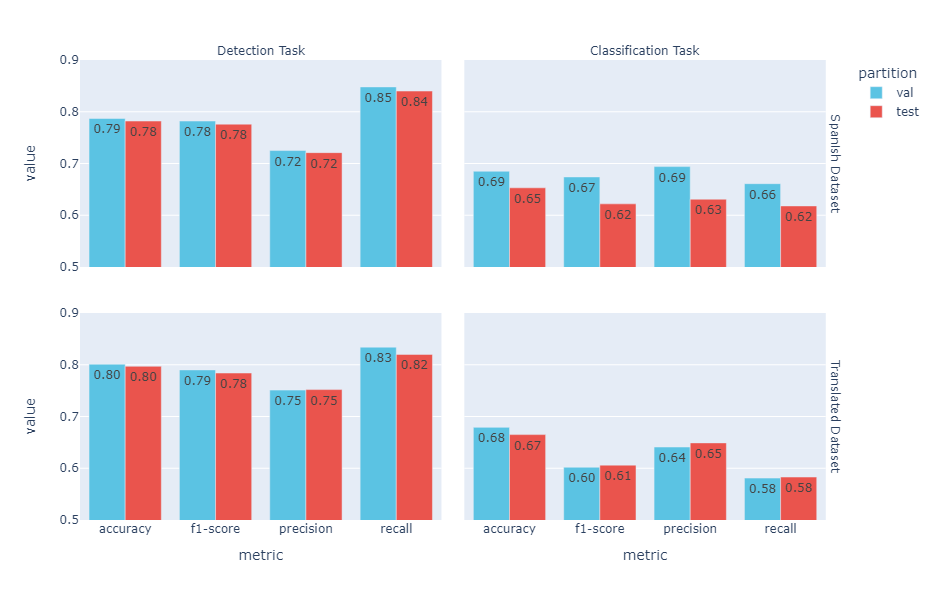

In [450]:
idx = pd.MultiIndex.from_tuples([("detection", "spanish"), 
                           ("detection", "translated"), 
                           ("classification", "spanish"), 
                           ("classification", "translated")], names=["task", "dataset"])
cols = pd.MultiIndex.from_tuples([("accuracy", "val"), 
                                  ("accuracy", "test"), 
                                  ("f1-score", "val"), 
                                  ("f1-score", "test"),
                                  ("precision", "val"), 
                                  ("precision", "test"), 
                                  ("recall", "val"), 
                                  ("recall", "test")], names=["metric", "partition"])
results = pd.DataFrame(data=[
    [ 0.787, 0.782, 0.782, 0.776, 0.725, 0.721, 0.848, 0.840 ],
    [ 0.801, 0.797, 0.790, 0.784, 0.751, 0.752, 0.834, 0.820 ],
    [ 0.685, 0.653, 0.674, 0.622, 0.694, 0.631, 0.661, 0.618 ],
    [ 0.679, 0.665, 0.602, 0.606, 0.641, 0.649, 0.581, 0.583 ]
], index=idx, columns=cols)

res = results.melt(ignore_index=False).reset_index()

fig = px.bar(
    res, 
    x="metric", 
    y="value", 
    color="partition", 
    color_discrete_sequence = [BLUE2, RED],
    facet_col="task", 
    facet_row="dataset",         
    facet_row_spacing=0.1, 
    facet_col_spacing=0.03,
    barmode="group", 
    range_y=(0.5, 0.9), 
    text_auto='.2f',
    category_orders={"task": ["detection", "classification"]}
)

fig.for_each_annotation(lambda a: a.update(text=" ".join(reversed(a.text.split("="))).title()))

fig.update_layout(
    autosize=False,
    width=700,
    height=600,)
fig.show()

In the detection task, the model trained on the Spanish dataset achieved F1 scores of 0.782 on the validation set and 0.776 on the test set. However, when incorporating the translated and synthetic instances, the F1 scores notably improved to 0.790 on the validation set and 0.784 on the test set. These results demonstrate that including additional data sources did not compromise the model's performance but instead led to significant improvements in detecting the target content.

In the classification task, the model trained on the Spanish dataset achieved F1 scores of 0.674 on the validation set and 0.622 on the test set. Upon incorporating the translated and synthetic instances, there was a slight decrease in the F1 scores, resulting in scores of 0.602 on the validation set and 0.606 on the test set. However, it is worth noting that the F1 scores remained relatively stable, indicating that the model's performance was not significantly impacted.

We hypothesize that the decrease in the classification task may be attributed to the challenge of homogenizing label sets from different data sources, introducing noise and ambiguity during the training process. Future work could focus on refining the label assignment process and exploring techniques to handle label heterogeneity, potentially resulting in improved performance for the classification model.

Overall, our experiments demonstrate the effectiveness of leveraging translated and synthetic instances to enhance the performance of the models. The inclusion of additional data sources led to notable improvements in the detection task and maintained relatively stable results in the classification task. These findings highlight the value of using large language models to obtain labeled instances for text classification in languages with limited labeled resources. By overcoming the limitations of scarce labeled data, this approach opens up new possibilities for applying artificial intelligence and machine learning in diverse linguistic contexts.